In [1]:
from mpi4py import MPI
from petsc4py import PETSc

import dolfinx.fem.petsc

import ufl
import numpy as np

from dolfinx import mesh, fem, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
L = 1
W = 0.2
mu = 1
rho = 1
delta = W / L
gamma = 0.4 * delta**2
beta = 1.25
lambda_ = beta
g = gamma

In [3]:
domain = mesh.create_box(MPI.COMM_WORLD, [np.array([0, 0, 0]), np.array([L, W, W])],
                         [20, 6, 6], cell_type=mesh.CellType.hexahedron)
V = fem.functionspace(domain, ("Lagrange", 1, (3,)))

def clamped_boundary(x):
    return np.isclose(x[0], 0)


fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, clamped_boundary)

u_D = np.array([0, 0, 0], dtype=default_scalar_type)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets), V)

In [4]:
T = fem.Constant(domain, default_scalar_type((0, 0, 0)))
ds = ufl.Measure("ds", domain=domain)

In [5]:
def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)


def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)


u = fem.Function(V)
u_hat = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, default_scalar_type((0, 0, -rho * g)))
a = ufl.inner(sigma(u_hat), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

F = ufl.inner(sigma(u), epsilon(v)) * ufl.dx - ufl.dot(f, v) * ufl.dx - ufl.dot(T, v) * ds
J = ufl.derivative(F, u, u_hat)

In [6]:
problem = LinearProblem(J, -F, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [7]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh2 = problem.solve()

In [8]:
(uh2.vector - uh.vector).norm()

7.810479786590377e-16

In [9]:
F_compiled = fem.form(F)
J_compiled = fem.form(J)

# Point to expand around
u_0 = fem.Function(V)
u_0.x.array[:] = uh.x.array

u.x.array[:] = u_0.x.array

# Residual
F_u = fem.petsc.assemble_vector(F_compiled)
F_u.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

# Jacobian (first derivative)
J_u = fem.petsc.assemble_matrix(J_compiled)
J_u.assemble()

delta_u = fem.Function(V)
delta_u.x.array[:] = uh.x.array
hs = np.logspace(-4.0, -1.0, 6)[::-1]

# To store Jacobian vector product
y = J_u.createVecLeft()
J_u.mult(delta_u.vector, y)

first_order_remainder = np.zeros_like(hs)
second_order_remainder = np.zeros_like(hs)

for i, h in enumerate(hs):
    u.x.array[:] = u_0.x.array + h * delta_u.x.array

    F_u_delta = fem.petsc.assemble_vector(F_compiled)
    F_u_delta.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    first_order_remainder[i] = (F_u_delta - F_u).norm()

    y = J_u.createVecLeft()
    J_u.mult(delta_u.vector, y)
    y.scale(h)

    second_order_remainder[i] = (F_u_delta - F_u - y).norm()

print(first_order_remainder)
print(second_order_remainder)

first_order_rate = np.polyfit(np.log(hs), np.log(first_order_remainder), 1)[0]
second_order_rate = np.polyfit(np.log(hs), np.log(second_order_remainder), 1)[0]

print(first_order_rate)
print(second_order_rate)

[7.54078381e-05 1.89415925e-05 4.75791293e-06 1.19513369e-06
 3.00204011e-07 7.54078381e-08]
[4.30585837e-17 4.10959741e-17 4.20794754e-17 3.71707117e-17
 3.78469071e-17 4.06657834e-17]
1.0000000000000875
0.013587099208073918


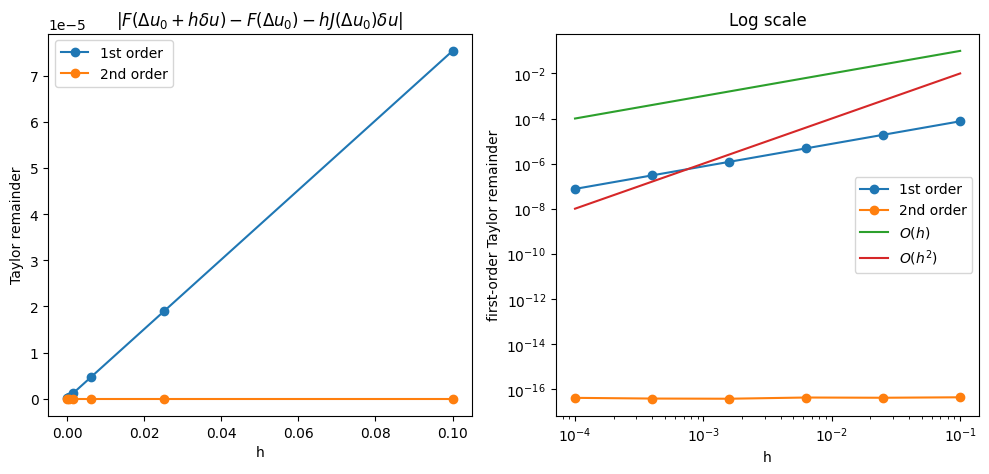

1.0000000000000875
0.013587099208073918


In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(hs, first_order_remainder, 'o-', label="1st order")
axs[0].plot(hs, second_order_remainder, 'o-', label="2nd order")
axs[0].set_title(r"$|F(\Delta u_0 + hδu) - F(\Delta u_0) - hJ(\Delta u_0)δu|$")
axs[0].set_ylabel('Taylor remainder')
axs[0].set_xlabel('h')
axs[0].legend()

axs[1].loglog(hs, first_order_remainder, 'o-', label="1st order")
axs[1].loglog(hs, second_order_remainder, 'o-', label="2nd order")
axs[1].loglog(hs, hs, label=r"$O(h)$")
axs[1].loglog(hs, hs**2, label=r"$O(h^2)$")
axs[1].set_title("Log scale")
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_ylabel('first-order Taylor remainder')
axs[1].set_xlabel('h')

plt.tight_layout()
plt.show()
first_order_rate = np.polyfit(np.log(hs), np.log(first_order_remainder), 1)[0]
second_order_rate = np.polyfit(np.log(hs), np.log(second_order_remainder), 1)[0]

print(first_order_rate)
print(second_order_rate)

In [11]:
# F(Du0 + h*δu) - F(Du0) - h*J(Du0)*δu
def scalar_Taylor_test(F, J, u, u0=0.01):
    u_0 = fem.Function(V)
    u_0.x.array[:] = u0 
    u.x.array[:] = u_0.x.array 
    delta_u = fem.Function(V)
    delta_u.x.array[:] = u0

    F_scalar = ufl.algorithms.compute_form_action(F, u)
    F_scalar_form = fem.form(F_scalar)
    F0 = fem.assemble_scalar(F_scalar_form) # F(Du0)

    J_vector = ufl.algorithms.compute_form_action(J, u)
    J_vector_form = fem.form(J_vector)
    J0 = fem.petsc.assemble_vector(J_vector_form) # J(Du0)
    J0_dot_δu = J0.dot(delta_u.vector) # dJ(Du0)*δu

    h_list = np.logspace(-4.0, -1.0, 6)[::-1]
    first_order_remainder = np.zeros_like(h_list)
    second_order_remainder = np.zeros_like(h_list)

    for i, h in enumerate(h_list):
        u.x.array[:] = u_0.x.array + h * delta_u.x.array

        F_scalar = fem.assemble_scalar(F_scalar_form)

        first_order_remainder[i] = np.abs(F_scalar - F0)
        second_order_remainder[i] = np.abs(F_scalar - F0 - h * J0_dot_δu)

    return first_order_remainder, second_order_remainder

In [12]:
# dummy = np.copy(uh.x.array)
# dummy.reshape((-1, 3))[:] = np.array([0, 0, 0.001])
first_order_remainder, second_order_remainder = scalar_Taylor_test(F, J, u, uh.x.array)

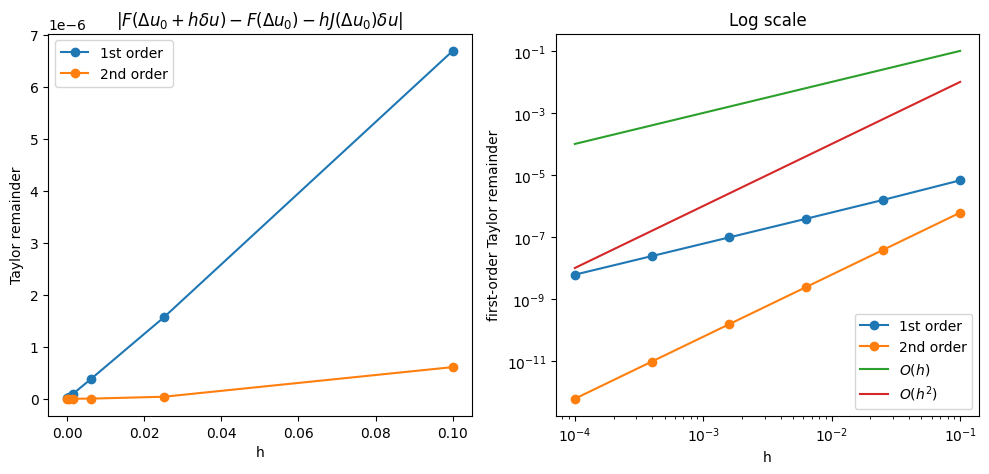

1.0114568676494626
1.9999999395288823


In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(hs, first_order_remainder, 'o-', label="1st order")
axs[0].plot(hs, second_order_remainder, 'o-', label="2nd order")
axs[0].set_title(r"$|F(\Delta u_0 + hδu) - F(\Delta u_0) - hJ(\Delta u_0)δu|$")
axs[0].set_ylabel('Taylor remainder')
axs[0].set_xlabel('h')
axs[0].legend()

axs[1].loglog(hs, first_order_remainder, 'o-', label="1st order")
axs[1].loglog(hs, second_order_remainder, 'o-', label="2nd order")
axs[1].loglog(hs, hs, label=r"$O(h)$")
axs[1].loglog(hs, hs**2, label=r"$O(h^2)$")
axs[1].set_title("Log scale")
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_ylabel('first-order Taylor remainder')
axs[1].set_xlabel('h')

plt.tight_layout()
plt.show()
first_order_rate = np.polyfit(np.log(hs), np.log(first_order_remainder), 1)[0]
second_order_rate = np.polyfit(np.log(hs), np.log(second_order_remainder), 1)[0]

print(first_order_rate)
print(second_order_rate)

In [14]:
# # Taylor remainder test starting with the residual
# mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
# V = dolfinx.fem.functionspace(mesh, ("CG", 1))

# u = dolfinx.fem.Function(V)
# u_tilde = ufl.TestFunction(V)
# u_bar = ufl.TrialFunction(V)

# Pi = u**3 * dx
# F = derivative(Pi, u, u_tilde)
# J = derivative(F, u, u_bar)

# F_compiled = dolfinx.fem.form(F)
# J_compiled = dolfinx.fem.form(J)

# # Point to expand around
# u_0 = dolfinx.fem.Function(V)
# u_0.x.array[:] = 1.0

# u.x.array[:] = u_0.x.array

# # Residual
# F_u = dolfinx.fem.petsc.assemble_vector(F_compiled)
# F_u.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

# # Jacobian (first derivative)
# J_u = dolfinx.fem.petsc.assemble_matrix(J_compiled)
# J_u.assemble()

# delta_u = dolfinx.fem.Function(V)
# delta_u.interpolate(lambda x: x[0] + x[1])

# hs = np.logspace(-4.0, -1.0, 6)[::-1]

# # To store Jacobian vector product
# y = J_u.createVecLeft()

# first_order_remainder = np.zeros_like(hs)
# second_order_remainder = np.zeros_like(hs)

# for i, h in enumerate(hs):
#     u.x.array[:] = u_0.x.array + h * delta_u.x.array

#     F_u_delta = dolfinx.fem.petsc.assemble_vector(F_compiled)
#     F_u_delta.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

#     first_order_remainder[i] = (F_u_delta - F_u).norm()

#     J_u.mult(delta_u.vector, y)
#     y.scale(h)

#     second_order_remainder[i] = (F_u_delta - F_u - y).norm()

# print(first_order_remainder)
# print(second_order_remainder)

# first_order_rate = np.polyfit(np.log(hs), np.log(first_order_remainder), 1)[0]
# second_order_rate = np.polyfit(np.log(hs), np.log(second_order_remainder), 1)[0]

# print(first_order_rate)
# print(second_order_rate)